# 3.4 차원 축소, 특성 추출, 매니폴드 학습

1. 비음수 행렬 분해
2. 2차원 산점도를 이용해 시각화 용도로 많이 사용하는 t-SNE 알고리즘

## 3.4.1 주성분 분석(PCA)

In [2]:
import mglearn
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from matplotlib import font_manager
import matplotlib
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
print(font_family)

Malgun Gothic


In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/malgun.ttf'

font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family

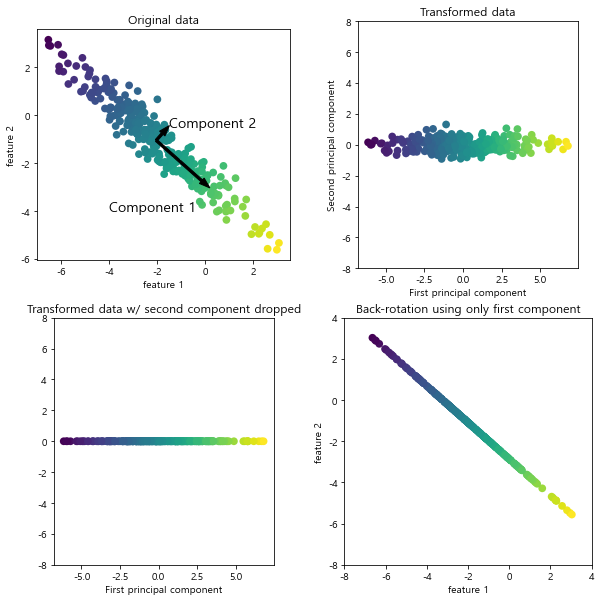

In [6]:
mglearn.plots.plot_pca_illustration()

### PCA를 적용해 유방암 데이터셋 시각화하기

PCA가 가장 널리 사용되는 분야는 고차원 데이터셋의 시각화입니다.

In [13]:
cancer.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

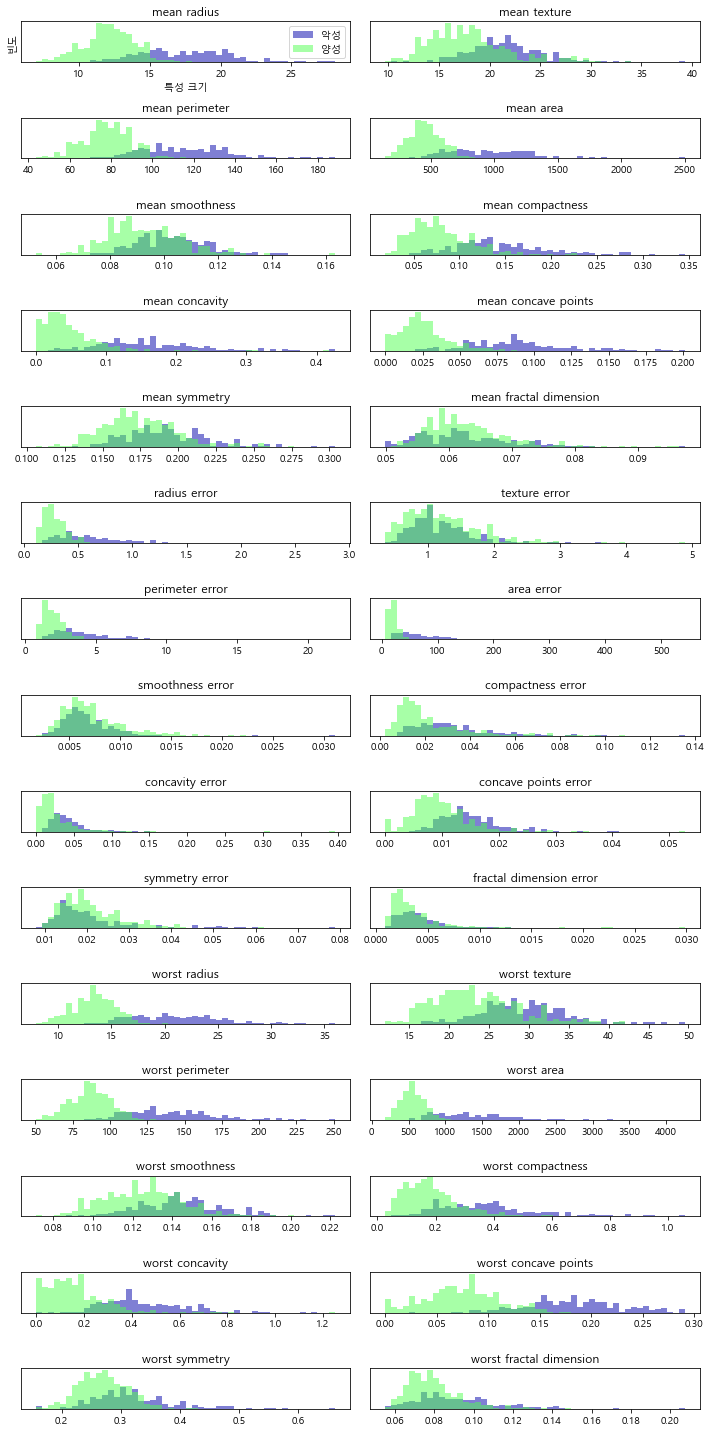

In [11]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)    
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("특성 크기")
ax[0].set_ylabel("빈도")
ax[0].legend(["악성", "양성"], loc="best")
fig.tight_layout()